## Predictive Maintenance

Chuming DAI (cdaiab) (explored the 3rd project on image captioning),

Qing DU (qduac) (preliminary analysis on data and built the random forest models),

Jiahao HE (jhebe) (preliminary analysis on data and built the LSTM model),

Aoyu WU (awuac) (built and tested models).

\* *Names in alphabetical order*

In this notebook, we explore possibilities of predicting the next-day equipment failure using historical data of the error messages. Specifically, we would like to predict wheather the equipment will fail (0 for normal operation, 1 for failure) on a given day based on the following features of the previous days: for each of the 26 types of error messages,

1. the number of occurences in a day,
2. the timestamp of the first occurence in a day,
3. the timestamp of the last occurence in a day,
4. the mean of the timestamps of all the occurences in a day, and
5. the standard deviation of the timestamps of all the occurences in a day.

Our experiment follows the following pipeline:

1. preliminary statistical analysis on the given data,
2. simple random forest model using Sklearn,
3. chained random forest model extended from the simple RF model, and
4. LSTM using Keras.

**Conclusions**:

1. The counts of error messages does not have linear correlation with the labels.
2. If using the features of the same time window to predict the each future days independently, the larger time window brings more distractions to the predictions.
3. Time series data can reveal dependencies of the labels for consecutive days.
4. We have not built a model that is predictive. All the models we tested perform badly as the AUC scores are all around 50% ~ 60%. Some major difficulties are imbalance of labels (only 6% positive labels), limited data (only 600 for training), and thin features (the min, max, mean, and std of timestamps are not effective predictors as they do not contain much information; moreover, the features are sparse).

The first 3 cells are imports and some useful functions to do parallel computing on cpu and data processing.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from multiprocessing import Pool
import warnings
warnings.filterwarnings('ignore')
path = '/home/data/predictive-maintenance1/'

In [3]:
from multiprocessing import cpu_count, Pool
import subprocess, os, signal, sys

def kill_child_processes(signum, frame):
    parent_id = os.getpid()
    ps_command = subprocess.Popen("ps -o pid --ppid %d --noheaders" % parent_id, shell=True, stdout=subprocess.PIPE)
    ps_output = ps_command.stdout.read()
    retcode = ps_command.wait()
    for pid_str in ps_output.strip().split("\n")[:-1]:
        print(pid_str)
        os.kill(int(pid_str), signal.SIGTERM)
    sys.exit()

def parallelize(data, func):
    cores = cpu_count()
    partitions = cores
    pool = Pool(cores)
    result = pool.map(func, data)
    signal.signal(signal.SIGTERM, kill_child_processes)
    pool.close()
    pool.join()
    return result

In [4]:
def iterate(col, backward=True):
    '''
    This function rearranges the input column of *df* by pushing it backward by one day.
    The input col MUST be sorted by *date*.
    :param col: pandas.Series, the column in *df* to be rearranged
    :return: pandas.Series, rearranged column
    '''
    n = len(df)
    result = [None]
    if backward == True:
        result.extend(col[0: -1])
    else:
        result = col[1:].tolist()
        result.append(None)
    return result

def add_nearby_days(n, _df, columns, forward=False, backward=False):
    '''
    This function adds the values of previous n days or the future n days of the given columns.
    :param n: int, number of days
    :param _df: pandas.DataFrame, the dataframe to be added to
    :return: pandas.DataFrame
    '''
    _df = _df.sort_values('date')
    for c in columns:
        if backward:
            for i in range(n):
                string = 'p_%s_%d' % (c, i+1)
                if i > 0:
                    name = 'p_%s_%d' % (c, i)
                    col = _df[name]
                else:
                    col = _df[c]
                _df[string] = iterate(col)
        if forward:
            for i in range(n):
                string = 'f_%s_%d' % (c, i+1)
                if i > 0:
                    name = 'f_%s_%d' % (c, i)
                    col = _df[name]
                else:
                    col = _df[c]
                _df[string] = iterate(col, backward=False)
    return _df

### Reading Data

The feature dataset consists of error records for 983 days. For each day, there are 131 features, namely the date and the "count, mean, std, min, max" for each of the 26 kinds of errors (131 = 1+26$\times$5). The label dataset indicates the state (OK or fail) of each day. 683 days are labeled. Our target is to predict the state of day(t) based on the features of day(0) until day(t-1).

In [5]:
features = pd.read_csv(path + 'feature.csv', header=[0,1], index_col=0)
labels = pd.read_csv(path + 'train_label.csv')
df = features.join(labels['label'])
df.rename(columns={('Unnamed: 1_level_0', 'date'): 'date'}, inplace=True)
df['date'] = pd.to_datetime(df.date, infer_datetime_format=True)

date1 = df.date.sort_values().tolist()[0]  # Start date of the data
date2 = df.date.sort_values().tolist()[-1]  # End date of the data
uniqe_dates = pd.date_range(date1, date2).tolist()  # Date range of the data

# Add feature: day of the week
df['day_of_week'] = df['date'].apply(lambda x: x.dayofweek + 1)
# Add feature: month
df['month'] = df['date'].apply(lambda x: x.month)
# Add feature: nth week of month
df['week_of_month'] = df['date'].apply(lambda x: x.day // 7 + 1)

Feature list:

In [11]:
print(df.columns.tolist())

['date', ('count', '136088194'), ('count', '136088202'), ('count', '136088394'), ('count', '136088802'), ('count', '136089546'), ('count', '136110468'), ('count', '136216674'), ('count', '136222202'), ('count', '136222210'), ('count', '136222234'), ('count', '136222250'), ('count', '136222882'), ('count', '136223186'), ('count', '136224578'), ('count', '136224586'), ('count', '136224978'), ('count', '136225010'), ('count', '136675426'), ('count', '136675626'), ('count', '136676578'), ('count', '136676650'), ('count', '136676666'), ('count', '136676682'), ('count', '136676698'), ('count', '136676714'), ('count', '136676754'), ('max', '136088194'), ('max', '136088202'), ('max', '136088394'), ('max', '136088802'), ('max', '136089546'), ('max', '136110468'), ('max', '136216674'), ('max', '136222202'), ('max', '136222210'), ('max', '136222234'), ('max', '136222250'), ('max', '136222882'), ('max', '136223186'), ('max', '136224578'), ('max', '136224586'), ('max', '136224978'), ('max', '136225

In [6]:
count_cols = [col for col in df.columns if col[0] == 'count']  # Columns of count
mean_cols = [col for col in df.columns if col[0] == 'mean']  # Columns of mean
max_cols = [col for col in df.columns if col[0] == 'max']  # Columns of the last occurence timestamp
min_cols = [col for col in df.columns if col[0] == 'min']  # Columns of the first occurence timestamp
std_cols = [col for col in df.columns if col[0] == 'std']  # Columns of standard deviation

cols = count_cols + mean_cols + max_cols + min_cols + std_cols  # All Columns of the original given features
# Fill NaN values with -1
df.update(df[cols].fillna(-1))
df_original = df

### Preliminary analysis

##### Dependency of failure with counts

We plot here some of the count features and mark the fail days with yellow cross.

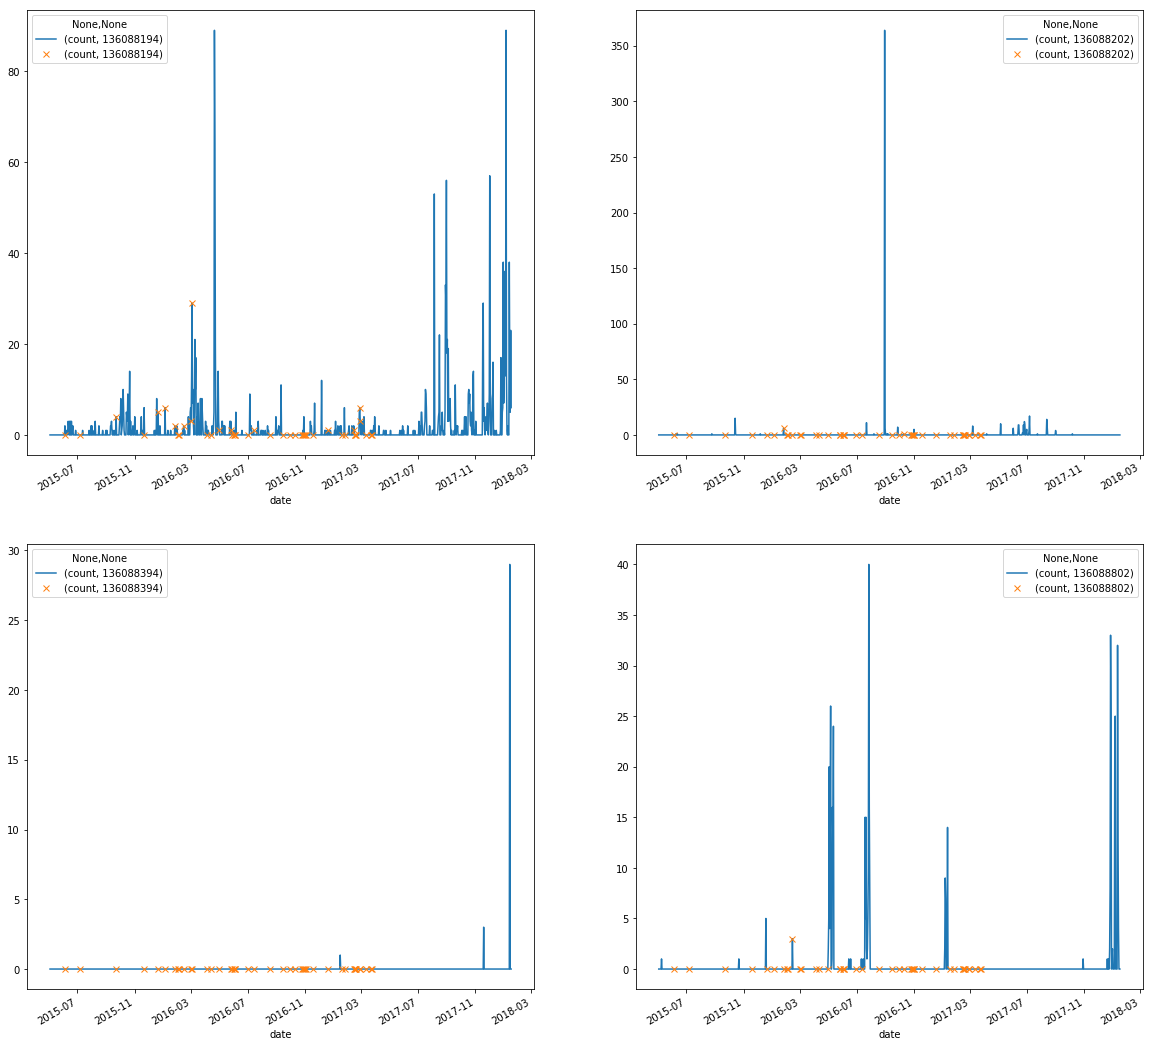

In [13]:
zeros = df[df.label==0]
ones = df[df.label==1]
ids = [col[1] for col in df_original.columns if col[0]=='count']
plt.figure(figsize=(20,20))
i=1
for j in ids[0:4]:
    ax = plt.subplot(2,2,i)
    i+= 1
    df.plot(x='date',y=('count',j), ax=ax)
    ones.plot(x='date',y=('count',j), ax=ax, style='x')

As shown below, no obvious relationship can be observed between a single feature on a single day, and the length of interarrival time of failures also decreases along time. Thus we intend to explore the dependency along time in the following plot.

##### Dependency of failure with time

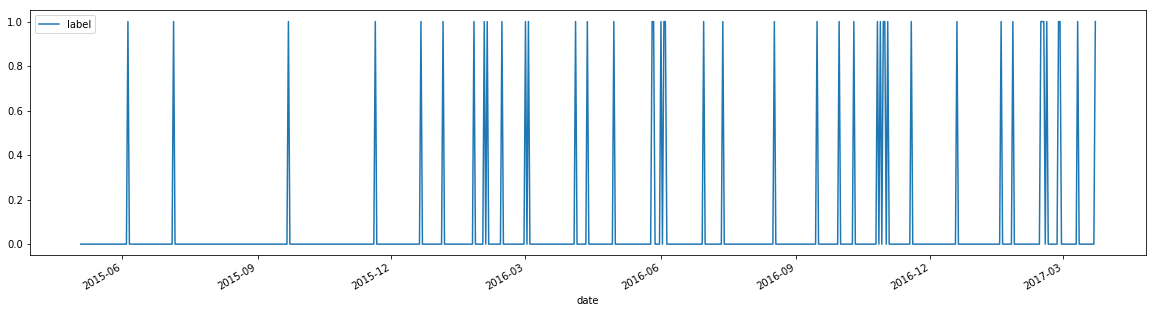

In [14]:
df[:683].plot(x='date', y='label', figsize=(20,5))

The plot shows that there are intervals that failures happen more frequently (e.g., 2015/2 to 2015/3, at the end of 2016/5, and 2016/11). At other times after 2015/12, the failure happens almost uniformly in time. 

##### Label imbalance

We calculate the percentage of positive labels in the data set:

In [15]:
# Split the dataset into training set (with labels) and test set (without labels).
df_train = df_original[df_original.date < '2017-3-24']
df_test = df_original[df_original.date >= '2017-3-24']

# Percentage of positive labels
df_train['label'].sum()/len(df_train)

0.0629575402635432

It shows that only 6% of the data has positive labels.

##### Test correlations of counts with labels

We run a linear regression on the training set to see wheather there are linear correlations between the counts and the labels of the future days. We first add the labels of the next 5 days to each rows, to serve as y values. The number of 0 labels are downsampled to the same number of the positive labels before running the regression.

In [16]:
# Add labels of the future 5 days
n = 5
df_train = add_nearby_days(n, df_train, ['label'], forward=True)
f_cols = ['f_label_%d' % x for x in range(1, n+1)]  # Label columns
labeled_sample = df_train[pd.notnull(df_train[f_cols[0]]) & pd.notnull(df_train[f_cols[-1]])]

Linear regression model:

In [17]:
import statsmodels.api as sm

for i in range(n):
    # Downsample the zero labels
    ones = labeled_sample[labeled_sample[f_cols[i]] == 1]
    n_positive = int(labeled_sample[f_cols[i]].sum())
    zeros = labeled_sample[labeled_sample[f_cols[i]] == 0].sample(n=n_positive)
    resampled = pd.concat([zeros, ones])

    # Let X be the columns of counts
    X = resampled[count_cols]
    # Let Y be the label of the future ith day
    Y = resampled[f_cols[i]]

    # Create linear regression object
    X = sm.add_constant(X)
    regr = sm.OLS(Y, X)
    regr = regr.fit()

    print('Next', i+1, 'day')
    print('Coefficients: \n', np.array(regr.params[1:]))
    print('p-values: \n', np.array(regr.pvalues[1:]))
    print("Mean squared error: %.2f" % regr.mse_model)
    print('R^2 score: %.2f' % regr.rsquared, '\n')

Next 1 day
Coefficients: 
 [ 2.11258835e-02  1.21736961e-01 -2.30017198e-15 -9.77752561e-02
  1.57836749e-01 -7.74062422e-06 -5.41499966e-16 -1.78338711e-01
 -8.11209616e-02 -4.74212813e-02  2.78656743e-01  1.14178791e-02
 -4.76816082e-02  1.89979666e-01  5.52718265e-02  1.68123642e-05
 -2.31689275e-04 -7.84147602e-02  8.89440770e-18  4.76658171e-03
  2.84350567e-01  5.46523295e-03  2.07935151e-02  5.75690927e-02
 -1.77486284e-02  3.63412655e-04]
p-values: 
 [0.47387969 0.1916958  0.44384304 0.31299824 0.47702989 0.41453293
 0.00796742 0.25289432 0.10962958 0.74699889 0.25148572 0.40637297
 0.08420271 0.21781642 0.24060263 0.99891198 0.17458202 0.57717838
 0.84244007 0.9438316  0.23019214 0.90875157 0.684667   0.42923335
 0.71573136 0.94847528]
Mean squared error: 0.37
R^2 score: 0.41 

Next 2 day
Coefficients: 
 [ 3.34453655e-02  1.40231916e-02 -5.97002793e-13 -1.86503651e-02
  1.26163507e-01 -1.87008546e-04  1.19327464e+00 -3.88679530e-02
  5.87265336e-03  8.44527710e-02 -2.86513572e

The p-values of all the "count" features are high with respect to all the 5 day labels, which shows the insignificants of the "count" features in the linear model. The low $r^2$ values also indicates that there is no correlation between the "count" features and labels. This leads to our first attempt of the random forest model.

### Simple Random Forest Model

The random forest model is generally good at modelling non-linear correlations. Thus we use it as our first attempt. To deal with the label imbalance, we add weight 10:1 to the positive class. Further, with the hope that for model to capture time series information, we add to each row the features of the previous days. The labels for prediction are the labels of the next 5 days. In other words, suppose we add the features of previous 2 days, and to predict the future 5 days, and the current day is day(0), then we are using the features of day(-2), day(-1) and day(0) to predict whether the equipment will fail in day(1), day(2), ..., day(5) respectively. The support of multi-output by the `RandomForestClassifier` by Sklearn makes the task very simple.

In [23]:
def predict(train, test, model_type='rf', weight=10,
            output_score=False,
            output_model=False,
            output_prediction=False,
            seed=None):
    '''
    This function trains an RF model and makes predictions.
    :param train: DataFrame, training set
    :param test: DataFrame, test set to make prediction
    :param model_type: string, 'rf' for simple RF model, and 'chained_rf' for chained RF model
    :param weight: float, weight to put on positive class
    :param output_score: bool, True to set the output to AUC score
    :param output_prediction: bool, True to set the output to predicted values
    :param output_model: bool, True to set the output to the fitted model
    :param seed: float, the random seed to be passed on the model
    :return: AUC score, the fitted model, or predictions
    '''
    if seed is None:
        seed = int(time())
        
    # Define model
    weight = weight
    if model_type == 'rf':
        class_weight = {1: weight} if n_future_days == 1 else [{1: weight}]*n_future_days
        model = RandomForestClassifier(n_estimators=2000,
                                       class_weight=class_weight,
                                       n_jobs=-1, random_state=seed)
    elif model_type == 'chained_rf':
        class_weight = {1: weight}
        model = ChainedModel(n_estimators=2000,
                             class_weight=class_weight,
                             n_jobs=-1, random_state=seed)

    # Define inputs
    train = train[pd.notnull(train[f_cols[0]]) & pd.notnull(train[f_cols[-1]])].drop('date', axis=1)
    test = test.drop('date', axis=1)
    train_x = train.drop(f_cols+['label'], axis=1)
    train_y = train[f_cols]
    test_x = test.drop(f_cols+['label'], axis=1)
    test_y = test[f_cols]
    
    # Train and predict
    predicted = pd.DataFrame(columns=test_y.columns)
    model = model.fit(train_x, train_y)
    if model_type == 'rf':
        predicted = pd.DataFrame(
            np.array(model.predict_proba(test_x))[:,:,1].transpose(),
            columns=test_y.columns,
            index=test_y.index)
    elif model_type == 'chained_rf':
        predicted = pd.DataFrame(
            np.array(model.predict_proba(test_x)),
            columns=test_y.columns,
            index=test_y.index)

    # Outputs
    if output_score:
        # Get AUC score
        score = roc_auc_score(test_y, predicted)
        return score
    elif output_model:
        return model
    elif output_prediction:
        return predicted, test_y
    else:
        return model, predicted, score
    
def get_multiple_scores(n):
    '''Fit the model on the training set and score it on the validation set.'''
    pred_y, test_y = predict(train_set, validation_set, output_prediction=True, seed=n)
    scores = []
    for i in range(len(pred_y.columns)):
        scores.append(roc_auc_score(test_y.ix[:,i], pred_y.ix[:,i]))
    return scores

We would like to experiment in the relationship of the length of the time window and the failure of the equipments: **how long in advance can we predict for the failure? How long can the history influence the future?** We use the last 30 days in the training set to be the validation set to test the model performance on different rolling time windows of the history (the number of previous days of feature to be added as predictors). Specifically, we iterate over `n_past_days = 1, 2, 3, 4, and 5` as the number of previous days as pridictors of probability of failures in next 5 days. Since there are only 600+ data in the training set and only 30 data points in the validation set, the model can vary a lot each time we fit it. Thus, to make the test meaningful, we fit the model 100 times on the same training set and evaluate the 100 fitted models on the same validation set by AUC scores. The final score of the model will be the average AUC of the 100 fitted models.

In [24]:
n_future_days = 5
n = 100
scores = []

for n_past_days in range(6):
    # Add all features of the previous days
    df = add_nearby_days(n_past_days, df_original, cols, backward=True)
    # Add the labels for the future days for prediction
    df = add_nearby_days(n_future_days, df, ['label'], forward=True)

    # Add dummy features: day_of_week, month, day_of_month
    date_features = ['day_of_week', 'month', 'week_of_month']
    for d in date_features:
        df = df.join(pd.get_dummies(df[d], prefix=d)).drop(d, axis=1)

    # Split the dataset into training set (with labels) and test set (without labels).
    df_train = df[df.date < '2017-3-24']
    df_test = df[df.date >= '2017-3-24']

    # Delete data of the first few days without complete labels
    df_train = df_train.iloc[n_past_days:]

    # All data with complete true labeles
    f_cols = ['f_label_%d' % x for x in range(1, n_future_days+1)]
    labeled_sample = df_train[pd.notnull(df_train[f_cols[0]]) & pd.notnull(df_train[f_cols[-1]])]

    # Define training and validation set (last n days of data)
    val_date = labeled_sample.date.tolist()[-30]
    train_set = labeled_sample[(labeled_sample.date < val_date)]
    validation_set = labeled_sample[(labeled_sample.date >= val_date)]

    r = np.random.randint(1, 100000000)
    result = parallelize(range(r, r+n), get_multiple_scores)
    scores.append(np.array(result).sum(0)/n)
# native rf model

The AUC scores on each predicted day are as follows.

In [25]:
pd.DataFrame(scores,
             columns=['predicted day %s' % i for i in range(1,6)],
             index=['with features of previous %s days' % i for i in range(6)])

,predicted day 1,predicted day 2,predicted day 3,predicted day 4,predicted day 5
with features of previous 0 days,0.446605,0.594383,0.370185,0.453462,0.28660
with features of previous 1 days,0.591667,0.389938,0.483704,0.314663,0.30596
with features of previous 2 days,0.479198,0.395864,0.257716,0.288221,0.22200
with features of previous 3 days,0.442531,0.214938,0.224506,0.354231,0.25284
with features of previous 4 days,0.286358,0.209136,0.310617,0.405625,0.24880
with features of previous 5 days,0.266852,0.285802,0.358580,0.389135,0.22628


The best 2 scores falls at predicting the next day with features of 2 days (the current day and the previous day), and predicting the next 2nd day with only the features from the current day. The table shows that, the model becomes hardly predictive with more history information added, which means that the history can be a distraction for prediction. We also note that the predictors are myopic, in the sense that they does not influence the future too far away.

### Chained Random Forest Model

While the simple model predicts each label for the future days independently, we may want it to learn the dependencies among the outputs. For example, when the equipment fails on a certain day, there may be a higher chance that it will also fail on the next day (if repair is not prompt). If we describe the above simple model as

    {X} --> y1,
    {X} --> y2,
    {X} --> y3,
    ...,
   
the chained model can be best described as

    {X} --> y1,
    {X, y1} --> y2,
    {X, y1, y2} --> y3,
    ...
    
(*reference: "[Multi-Output Random Forests](http://astrohackweek.org/blog/multi-output-random-forests.html)" by Jake VanderPlas*).

We evaluate this chained model following the same procedures as above.

In [16]:
class ChainedModel(object):
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        
    def fit(self, X, Y):
        X, Y = map(np.atleast_2d, (X, Y))
        assert X.shape[0] == Y.shape[0]
        self.Ny = Y.shape[1]
        
        self.clfs = []
        for i in range(self.Ny):
            clf = RandomForestClassifier(**self.kwargs)
            Xi = np.hstack([X, Y[:, :i]])
            yi = Y[:, i]
            self.clfs.append(clf.fit(Xi, yi))
            if i == 0:
                self.feature_importances_ = clf.feature_importances_
            else:
                self.feature_importances_ += clf.feature_importances_[:-i]
        self.feature_importances_ /= self.Ny
        return self
        
    def predict(self, X):
        Y = np.empty([X.shape[0], len(self.clfs)])
        for i, clf in enumerate(self.clfs):
            Y[:, i] = clf.predict(np.hstack([X, Y[:, :i]]))
        return Y
    
    def predict_proba(self, X):
        Y = np.empty([X.shape[0], len(self.clfs)])
        for i, clf in enumerate(self.clfs):
            Y[:, i] = clf.predict_proba(np.hstack([X, Y[:, :i]]))[:, 1]
        return Y

def get_multiple_scores_chained(n):
    '''Fit the model on the training set and score it on the validation set.'''
    pred_y, test_y = predict(train_set, validation_set, model_type='chained_rf', output_prediction=True, seed=n)
    scores = []
    for i in range(len(pred_y.columns)):
        scores.append(roc_auc_score(test_y.ix[:,i], pred_y.ix[:,i]))
    return scores

In [26]:
scores_chained = []

for n_past_days in range(6):
    # Add all features of the previous days
    df = add_nearby_days(n_past_days, df_original, cols, backward=True)
    # Add the labels for the future days for prediction
    df = add_nearby_days(n_future_days, df, ['label'], forward=True)

    # Add dummy features: day_of_week, month, day_of_month
    date_features = ['day_of_week', 'month', 'week_of_month']
    for d in date_features:
        df = df.join(pd.get_dummies(df[d], prefix=d)).drop(d, axis=1)

    # Split the dataset into training set (with labels) and test set (without labels).
    df_train = df[df.date < '2017-3-24']
    df_test = df[df.date >= '2017-3-24']

    # Delete data of the first few days without complete labels
    df_train = df_train.iloc[n_past_days:]

    # All data with complete true labeles
    f_cols = ['f_label_%d' % x for x in range(1, n_future_days+1)]
    labeled_sample = df_train[pd.notnull(df_train[f_cols[0]]) & pd.notnull(df_train[f_cols[-1]])]

    # Define training and validation set (last n days of data)
    val_date = labeled_sample.date.tolist()[-30]
    train_set = labeled_sample[(labeled_sample.date < val_date)]
    validation_set = labeled_sample[(labeled_sample.date >= val_date)]

    r = np.random.randint(1, 100000000)
    result = parallelize(range(r, r+n), get_multiple_scores_chained)
    scores_chained.append(np.array(result).sum(0)/n)
    # chained rf model

The AUC scores on each predicted day are as follows.

In [27]:
pd.DataFrame(scores_chained,
             columns=['predicted day %s' % i for i in range(1,6)],
             index=['with features of previous %s days' % i for i in range(6)])

,predicted day 1,predicted day 2,predicted day 3,predicted day 4,predicted day 5
with features of previous 0 days,0.542469,0.641358,0.357469,0.348510,0.33204
with features of previous 1 days,0.573272,0.430556,0.323889,0.241298,0.30364
with features of previous 2 days,0.410926,0.305309,0.131852,0.188269,0.24036
with features of previous 3 days,0.258642,0.077963,0.107840,0.193221,0.25756
with features of previous 4 days,0.049444,0.113272,0.160741,0.268029,0.27000
with features of previous 5 days,0.086728,0.137222,0.184012,0.258077,0.33712


The best score falls at predicting the future 2nd day with only the features on the current day (without more history data). We notice an interesting phenomenon that for the first three rows, the AUC scores decrease w.r.t the day of prediction, but increase significantly in the last two rows (although they are still very bad). This result shows that, with more historical information provided, the time series data may reveal the correlation among the outputs.

### LSTM

We use a single layer LSTM with 24 units to do the classification. To deal with the unstability of randomness when fitting the model, we train the identical model 20 times with distinct random seeds and take the median of the output to get more robust result.

In [7]:
num_feature_sp = len(list(df_original))-2

def prepare_data(df, days_past=1, days_predict=1, val_size=100):
#     encode history
    dseries = add_nearby_days(days_past, df, df.columns, backward=True)
    dseries = add_nearby_days(days_predict, dseries, ['label'], forward=True)
    dates = ['p_date_%d' % j for j in range(1,days_past+1)]
    dseries = dseries.drop(dates, axis=1)

    df_train = dseries[dseries.date < '2017-3-24']
    df_test = dseries[dseries.date >= '2017-3-24']

    # All data with complete true labeles
    f_cols = ['f_label_%d' % x for x in range(1, days_predict+1)]
    labeled_sample = dseries[pd.notnull(dseries[f_cols[0]]) & pd.notnull(dseries[f_cols[-1]])]
        
    # Split training and validation set (last val_size days of data)
    if val_size>0:
        val_date = labeled_sample.date.tolist()[-val_size]
    else:
        val_date = '2017-3-24'

    # Label columns are *f_cols*, others are feature columns
    f_cols = ['f_label_%d' % x for x in range(1, days_predict+1)]
    p_cols = ['p_label_%d' % x for x in range(1, days_past+1)]
    f_cols = f_cols+p_cols+['label']
    
    train_set = labeled_sample[(labeled_sample.date < val_date)].iloc[1+days_past:]
    train_X = train_set.drop(f_cols+['date'], axis = 1)
    train_Y = train_set.f_label_1
    # Scale data to (-1,1)
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaled_train_X = pd.DataFrame(scaler.fit_transform(train_X))
    scaled_train_X.columns = train_X.columns
    train_feature = scaled_train_X.values
    train_label = train_Y.values
    train_feature = train_feature.reshape((train_feature.shape[0], days_past+1, num_feature_sp))
    
    if val_size > 0:
        validation_set = labeled_sample[(labeled_sample.date >= val_date)]
        val_X = validation_set.drop(f_cols+['date'], axis = 1)
        val_Y = validation_set.f_label_1
        scaled_val_X = pd.DataFrame(scaler.transform(val_X))
        scaled_val_X.columns = val_X.columns
        scaled_train_X = scaled_train_X
        val_feature = scaled_val_X.values
        val_label = val_Y.values
        val_feature = val_feature.reshape((val_feature.shape[0], days_past+1, num_feature_sp))
    else:
        val_feature = {}
        val_label = {}

    test_X = df_test.drop(f_cols+['date'], axis=1)
    scaled_test_X = pd.DataFrame(scaler.transform(test_X))
    scaled_test_X.colmuns = train_X.columns
    test_feature = scaled_test_X.values
    test_feature = test_feature.reshape((test_feature.shape[0], days_past+1, num_feature_sp))
    
    return train_feature, val_feature, train_label, val_label, test_feature

def compute(n, past=30, val_size=50, state=True):
    np.random.seed(n)
    from keras import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.layers import Dropout
    
#     construct RNN
    if state == False:
        X_train, X_val, Y_train, Y_val, X_test = prepare_data(df, days_past = past, val_size = val_size)
        model = Sequential()
        model.add(LSTM(24, input_shape=(X_train.shape[1], X_train.shape[2]), stateful=False))
        model.add(Dropout(0.2))
        model.add((Dense(1, activation = 'sigmoid')))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['acc'])
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
    #   fit network
        if val_size > 0:
            history = model.fit(X_train, Y_train , epochs=50, verbose=0, shuffle=True,class_weight={1:10, 0:1})
        else:
            print('in')
            history = model.fit(X_train, Y_train, epochs=50, verbose=0, shuffle=True, class_weight={1:10, 0:1})
        
        if val_size > 0:
            val_y_predict = model.predict(X_val)
            fpr, tpr,  _= roc_curve(Y_val, val_y_predict)
            crit = auc(fpr, tpr)
            plt.plot(fpr, tpr)
            return  crit

        else:
            y = model.predict(np.concatenate((X_train,X_test), axis=0))
            return y
    
#     compute AUC for validation data
    if state == True:
        X_train, X_val, Y_train, Y_val, X_test = prepare_data(df_original, days_past = 0, val_size = val_size)
        model = Sequential()
        model.add(LSTM(25, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]),stateful=True))
        model.add(Dropout(0.2))
        model.add((Dense(1, activation = 'sigmoid')))
        model.compile(loss='binary_crossentropy', optimizer='adam')
        
        #   fit network
        if val_size > 0:
            for j in range(100):
                history = model.fit(X_train, Y_train,batch_size = 1, epochs=1, verbose=2, shuffle=False)
                model.reset_states()
        else:
            history = model.fit(X_train, Y_train, batch_size = 1, epochs=100, verbose=0, shuffle=False, class_weight={1:5, 0:1})
        if val_size > 0:
            y = model.predict(np.concatenate((X_train,X_val, X_test), axis=0), batch_size=1)
            return  y

        else:
            y = model.predict(np.concatenate((X_train,X_val, X_test), axis=0), batch_size=1)
            return y

In [13]:
seed = np.random.randint(1,10000000)
diff = np.random.randint(1,10000000)
a = np.array([[diff*i+seed, 30, 50 , True] for i in range(0,20)])
x = parallelize(a, compute)

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
 - 2s - loss: 0.2284
Epoch 1/1
 - 3s - loss: 0.2294
 - 3s - loss: 0.2340
Epoch 1/1
 - 3s - loss: 0.2330
 - 3s - loss: 0.2288
Epoch 1/1
 - 3s - loss: 0.2303
 - 2s - loss: 0.2262
Epoch 1/1
Epoch 1/1
 - 3s - loss: 0.2248
 - 3s - loss: 0.2353
Epoch 1/1
 - 3s - loss: 0.2303
Epoch 1/1
 - 3s - loss: 0.2318
 - 3s - loss: 0.2230
 - 3s - loss: 0.2232
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
 - 3s - loss: 0.2245
 - 3s - loss: 0.2260
Epoch 1/1
 - 3s - loss: 0.2350
Epoch 1/1
 - 3s - loss: 0.2337
 - 3s - loss: 0.2319
Epoch 1/1
Epoch 1/1
Epoch 1/1
 - 3s - loss: 0.2247
 - 3s - loss: 0.2292
Epoch 1/1
Epoch 1/1
 - 2s - loss: 0.2187
Epoch 1/1
 - 2s - loss: 0.2243
Epoch 1/1
 - 2s - loss: 0.2224
Epoch 1/1
 - 2s - loss: 0.2302
Epoch 1/1
 - 2s - loss: 0.2180
Epoch 1/1
 - 3s - loss: 0.2041
Epoc

 - 3s - loss: 0.2107
 - 2s - loss: 0.2177
Epoch 1/1
Epoch 1/1
 - 3s - loss: 0.2173
Epoch 1/1
 - 2s - loss: 0.2171
Epoch 1/1
 - 3s - loss: 0.2205
Epoch 1/1
 - 2s - loss: 0.2143
Epoch 1/1
 - 2s - loss: 0.2093
Epoch 1/1
 - 2s - loss: 0.2132
Epoch 1/1
 - 2s - loss: 0.2246
Epoch 1/1
 - 3s - loss: 0.2121
 - 3s - loss: 0.2110
Epoch 1/1
Epoch 1/1
 - 2s - loss: 0.2130
Epoch 1/1
 - 3s - loss: 0.2160
Epoch 1/1
 - 2s - loss: 0.2138
Epoch 1/1
 - 3s - loss: 0.2210
Epoch 1/1
 - 2s - loss: 0.2193
Epoch 1/1
 - 2s - loss: 0.2154
Epoch 1/1
 - 3s - loss: 0.2140
Epoch 1/1
 - 2s - loss: 0.2122
Epoch 1/1
 - 3s - loss: 0.2078
Epoch 1/1
 - 2s - loss: 0.2099
Epoch 1/1
 - 3s - loss: 0.2158
Epoch 1/1
 - 3s - loss: 0.2147
Epoch 1/1
 - 2s - loss: 0.2116
Epoch 1/1
 - 3s - loss: 0.2101
Epoch 1/1
 - 2s - loss: 0.2177
Epoch 1/1
 - 3s - loss: 0.2173
Epoch 1/1
 - 3s - loss: 0.2162
Epoch 1/1
 - 3s - loss: 0.2193
Epoch 1/1
 - 2s - loss: 0.2114
Epoch 1/1
 - 3s - loss: 0.2099
Epoch 1/1
 - 2s - loss: 0.2145
Epoch 1/1
 - 3s - 

Epoch 1/1
 - 3s - loss: 0.2143
Epoch 1/1
 - 3s - loss: 0.2134
Epoch 1/1
 - 3s - loss: 0.2108
Epoch 1/1
 - 2s - loss: 0.2104
Epoch 1/1
 - 3s - loss: 0.2177
Epoch 1/1
 - 2s - loss: 0.2173
Epoch 1/1
 - 3s - loss: 0.2179
Epoch 1/1
 - 2s - loss: 0.2133
Epoch 1/1
 - 3s - loss: 0.2152
Epoch 1/1
 - 2s - loss: 0.2067
Epoch 1/1
 - 3s - loss: 0.2118
Epoch 1/1
 - 2s - loss: 0.2149
Epoch 1/1
 - 3s - loss: 0.2138
Epoch 1/1
 - 2s - loss: 0.2088
Epoch 1/1
 - 3s - loss: 0.2180
Epoch 1/1
 - 2s - loss: 0.2105
Epoch 1/1
 - 3s - loss: 0.2163
Epoch 1/1
 - 2s - loss: 0.2085
Epoch 1/1
 - 3s - loss: 0.2157
Epoch 1/1
 - 3s - loss: 0.2116
 - 3s - loss: 0.2095
Epoch 1/1
Epoch 1/1
 - 3s - loss: 0.2150
Epoch 1/1
 - 3s - loss: 0.2198
Epoch 1/1
 - 3s - loss: 0.2205
Epoch 1/1
 - 3s - loss: 0.2073
 - 3s - loss: 0.2048
Epoch 1/1
Epoch 1/1
 - 2s - loss: 0.2139
Epoch 1/1
 - 3s - loss: 0.2184
Epoch 1/1
 - 2s - loss: 0.2165
Epoch 1/1
 - 2s - loss: 0.2139
Epoch 1/1
 - 2s - loss: 0.2132
Epoch 1/1
 - 3s - loss: 0.2085
Epoch 1/

 - 2s - loss: 0.2131
Epoch 1/1
 - 2s - loss: 0.2106
Epoch 1/1
 - 2s - loss: 0.2086
Epoch 1/1
 - 3s - loss: 0.2091
Epoch 1/1
 - 3s - loss: 0.2087
Epoch 1/1
 - 3s - loss: 0.2075
Epoch 1/1
 - 3s - loss: 0.2112
Epoch 1/1
 - 2s - loss: 0.2071
Epoch 1/1
 - 3s - loss: 0.2089
Epoch 1/1
 - 3s - loss: 0.2114
Epoch 1/1
 - 3s - loss: 0.2151
Epoch 1/1
 - 3s - loss: 0.2051
Epoch 1/1
 - 2s - loss: 0.2133
Epoch 1/1
 - 3s - loss: 0.2085
Epoch 1/1
 - 2s - loss: 0.2160
Epoch 1/1
 - 2s - loss: 0.2031
Epoch 1/1
 - 3s - loss: 0.2116
Epoch 1/1
 - 3s - loss: 0.2060
Epoch 1/1
 - 3s - loss: 0.2073
Epoch 1/1
 - 2s - loss: 0.2144
Epoch 1/1
 - 3s - loss: 0.2145
Epoch 1/1
 - 2s - loss: 0.2079
Epoch 1/1
 - 2s - loss: 0.2109
Epoch 1/1
 - 3s - loss: 0.2115
Epoch 1/1
 - 2s - loss: 0.2099
Epoch 1/1
 - 3s - loss: 0.2040
Epoch 1/1
 - 3s - loss: 0.2059
Epoch 1/1
 - 3s - loss: 0.2037
Epoch 1/1
 - 2s - loss: 0.2086
Epoch 1/1
 - 2s - loss: 0.2126
Epoch 1/1
 - 2s - loss: 0.2035
Epoch 1/1
 - 2s - loss: 0.2099
Epoch 1/1
 - 3s - 

Epoch 1/1
 - 2s - loss: 0.2132
Epoch 1/1
 - 2s - loss: 0.2022
Epoch 1/1
 - 2s - loss: 0.2084
Epoch 1/1
 - 3s - loss: 0.2123
Epoch 1/1
 - 2s - loss: 0.2112
Epoch 1/1
 - 3s - loss: 0.2056
Epoch 1/1
 - 3s - loss: 0.1978
Epoch 1/1
 - 2s - loss: 0.2097
Epoch 1/1
 - 3s - loss: 0.2031
Epoch 1/1
 - 2s - loss: 0.2096
Epoch 1/1
 - 2s - loss: 0.2014
Epoch 1/1
 - 2s - loss: 0.2081
Epoch 1/1
 - 3s - loss: 0.2013
Epoch 1/1
 - 3s - loss: 0.1959
Epoch 1/1
 - 3s - loss: 0.2101
Epoch 1/1
 - 3s - loss: 0.2060
Epoch 1/1
 - 3s - loss: 0.2108
Epoch 1/1
 - 2s - loss: 0.2044
Epoch 1/1
 - 3s - loss: 0.2038
Epoch 1/1
 - 3s - loss: 0.2047
Epoch 1/1
 - 3s - loss: 0.2043
Epoch 1/1
 - 3s - loss: 0.2021
Epoch 1/1
 - 2s - loss: 0.2033
Epoch 1/1
 - 2s - loss: 0.2012
Epoch 1/1
 - 3s - loss: 0.2059
Epoch 1/1
 - 2s - loss: 0.2088
Epoch 1/1
 - 3s - loss: 0.2041
Epoch 1/1
 - 3s - loss: 0.2121
Epoch 1/1
 - 2s - loss: 0.2066
Epoch 1/1
 - 2s - loss: 0.2166
Epoch 1/1
 - 2s - loss: 0.2042
Epoch 1/1
 - 3s - loss: 0.2137
Epoch 1/

 - 2s - loss: 0.2016
Epoch 1/1
 - 2s - loss: 0.2017
Epoch 1/1
 - 2s - loss: 0.2055
Epoch 1/1
 - 3s - loss: 0.2018
Epoch 1/1
 - 3s - loss: 0.1980
Epoch 1/1
 - 3s - loss: 0.2015
Epoch 1/1
 - 3s - loss: 0.1970
Epoch 1/1
 - 3s - loss: 0.2099
 - 3s - loss: 0.2037
Epoch 1/1
Epoch 1/1
 - 3s - loss: 0.2042
Epoch 1/1
 - 3s - loss: 0.2003
Epoch 1/1
 - 2s - loss: 0.1933
Epoch 1/1
 - 2s - loss: 0.2073
Epoch 1/1
 - 2s - loss: 0.2052
Epoch 1/1
 - 3s - loss: 0.1992
Epoch 1/1
 - 3s - loss: 0.2037
Epoch 1/1
 - 2s - loss: 0.1951
Epoch 1/1
 - 2s - loss: 0.2039
Epoch 1/1
 - 3s - loss: 0.2017
Epoch 1/1
 - 2s - loss: 0.2094
Epoch 1/1
 - 2s - loss: 0.2059
Epoch 1/1
 - 2s - loss: 0.2001
Epoch 1/1
 - 2s - loss: 0.1910
Epoch 1/1
 - 3s - loss: 0.2005
Epoch 1/1
 - 3s - loss: 0.2036
Epoch 1/1
 - 2s - loss: 0.2011
Epoch 1/1
 - 2s - loss: 0.1990
Epoch 1/1
 - 2s - loss: 0.2102
Epoch 1/1
 - 3s - loss: 0.2071
Epoch 1/1
 - 3s - loss: 0.1982
Epoch 1/1
 - 2s - loss: 0.2034
Epoch 1/1
 - 2s - loss: 0.2053
Epoch 1/1
 - 2s - 

Epoch 1/1
 - 2s - loss: 0.1983
Epoch 1/1
 - 2s - loss: 0.1934
Epoch 1/1
 - 3s - loss: 0.1984
Epoch 1/1
 - 2s - loss: 0.2022
Epoch 1/1
 - 3s - loss: 0.2049
Epoch 1/1
 - 2s - loss: 0.1953
Epoch 1/1
 - 3s - loss: 0.1955
 - 3s - loss: 0.2007
Epoch 1/1
Epoch 1/1
 - 2s - loss: 0.1895
Epoch 1/1
 - 2s - loss: 0.2028
Epoch 1/1
 - 2s - loss: 0.1918
Epoch 1/1
 - 2s - loss: 0.2023
Epoch 1/1
 - 3s - loss: 0.1909
Epoch 1/1
 - 3s - loss: 0.1964
Epoch 1/1
 - 2s - loss: 0.1973
Epoch 1/1
 - 2s - loss: 0.2011
Epoch 1/1
 - 3s - loss: 0.1985
Epoch 1/1
 - 2s - loss: 0.2007
Epoch 1/1
 - 2s - loss: 0.1952
Epoch 1/1
 - 3s - loss: 0.1999
Epoch 1/1
 - 3s - loss: 0.1996
Epoch 1/1
 - 2s - loss: 0.1909
Epoch 1/1
 - 2s - loss: 0.1972
Epoch 1/1
 - 2s - loss: 0.2085
Epoch 1/1
 - 2s - loss: 0.2019
Epoch 1/1
 - 2s - loss: 0.2046
Epoch 1/1
 - 3s - loss: 0.1909
Epoch 1/1
 - 2s - loss: 0.1939
Epoch 1/1
 - 2s - loss: 0.1935
Epoch 1/1
 - 3s - loss: 0.1954
Epoch 1/1
 - 2s - loss: 0.1955
Epoch 1/1
 - 2s - loss: 0.2033
Epoch 1/

 - 2s - loss: 0.1958
Epoch 1/1
 - 3s - loss: 0.1929
Epoch 1/1
 - 2s - loss: 0.1955
Epoch 1/1
 - 3s - loss: 0.2031
Epoch 1/1
 - 3s - loss: 0.1896
Epoch 1/1
 - 2s - loss: 0.1909
Epoch 1/1
 - 3s - loss: 0.1927
Epoch 1/1
 - 2s - loss: 0.1895
Epoch 1/1
 - 3s - loss: 0.1955
Epoch 1/1
 - 3s - loss: 0.1964
Epoch 1/1
 - 2s - loss: 0.1989
Epoch 1/1
 - 2s - loss: 0.1850
Epoch 1/1
 - 3s - loss: 0.1962
Epoch 1/1
 - 3s - loss: 0.1916
Epoch 1/1
 - 2s - loss: 0.2071
Epoch 1/1
 - 2s - loss: 0.2052
Epoch 1/1
 - 2s - loss: 0.1895
Epoch 1/1
 - 2s - loss: 0.1905
Epoch 1/1
 - 2s - loss: 0.2042
Epoch 1/1
 - 3s - loss: 0.2031
Epoch 1/1
 - 2s - loss: 0.1982
Epoch 1/1
 - 3s - loss: 0.1915
Epoch 1/1
 - 2s - loss: 0.2004
Epoch 1/1
 - 2s - loss: 0.1947
Epoch 1/1
 - 3s - loss: 0.1987
Epoch 1/1
 - 3s - loss: 0.1936
Epoch 1/1
 - 2s - loss: 0.1983
Epoch 1/1
 - 2s - loss: 0.1818
Epoch 1/1
 - 3s - loss: 0.1860
Epoch 1/1
 - 3s - loss: 0.1962
Epoch 1/1
 - 3s - loss: 0.1944
Epoch 1/1
 - 3s - loss: 0.1769
Epoch 1/1
 - 3s - 

The following figure illustrate our result from LSTM. The blue line is the true label (ideal output), and the yellow line is our output. We use the data from day 633 to day 683 as validation set. As shown below, our output for the validation dates resembles the parttern of truth, but scaled down and missing one peak. We also get the aur_roc score around 0.64, which is not encouraging.

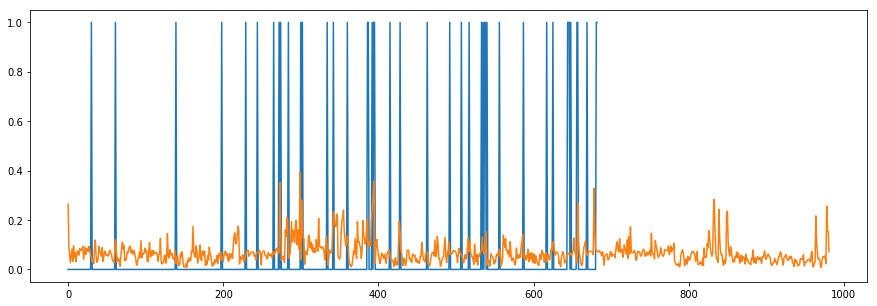

In [14]:
n = 20
meanx = [np.mean([x[i][j] for i in range(n)]) for j in range(0,len(x[0]))]
medianx = [np.median([x[i][j] for i in range(n)]) for j in range(0,len(x[0]))]
maxx = [max([x[i][j] for i in range(n)]) for j in range(0,len(x[0]))]
minx = [min([x[i][j] for i in range(n)]) for j in range(0,len(x[0]))]
stdx = [np.std([x[i][j] for i in range(n)]) for j in range(0,len(x[0]))]
truth = df.shift(-1).label.tolist()
plt.figure(figsize=(15,5))
# plt.plot(maxx)
# plt.plot(minx)
plt.plot(truth)
# plt.plot(meanx)
plt.plot(medianx)

0.6449864498644987


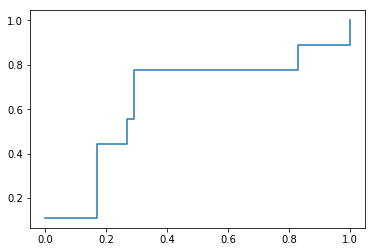

In [76]:
fpr, tpr, _ = roc_curve(np.reshape(truth[633:683],[-1,1]),np.reshape(medianx[633:683],[-1,1]))
plt.plot(fpr, tpr)
crit = auc(fpr, tpr)
print(crit)

### Predictions On the Test Set

Below are the predictions we made on the test set. The results were uploaded to Kaggle and got a 52.9% AUC score.

In [92]:
def train_and_test(n):
    random.seed(n)
    return predict(df_train, df_test, model_type='chained_rf', output_prediction=True, seed=n).f_label_1_predicted

n = 1000
r = random.randint(1, 100000000)
result = parallelize(range(r, r+n), train_and_test)
predicted_test = sum(result)/n
predicted_test = df[['date']].join(predicted_test).dropna()
predicted_test['date'] = (predicted_test['date'] + pd.DateOffset(1)).map(lambda x: '%s/%s/%s' % (x.date().day, x.date().month, x.date().year))
predicted_test.columns = ['date', 'label']

In [94]:
predicted_test

,date,label
683,25/3/2017,0.141300
684,26/3/2017,0.042465
685,27/3/2017,0.031439
686,28/3/2017,0.015821
687,29/3/2017,0.048868
688,30/3/2017,0.128236
689,31/3/2017,0.052795
690,1/4/2017,0.052422
691,2/4/2017,0.070039
692,3/4/2017,0.050143
